# Análise exploratória de preços do Etherium (ETH/USDT)

Descrição resumida
- Script em Python para baixar OHLCV do par ETHUSDT da API da Binance, limpar e preparar os dados, calcular métricas/indicadores simples e gerar visualizações exploratórias.
- Etapas implementadas: coleta, limpeza, estatísticas descritivas, visualizações, correlação e feature engineering (médias móveis e volatilidade).

Dependências
- requests
- pandas
- numpy
- matplotlib
- seaborn

Instalação (exemplo)
```bash
pip install requests pandas numpy matplotlib seaborn
```

Principais funções/variáveis
- get_binance_ohlc(symbol="ETHUSDT", interval="1d", start=1493596800000, end=None)
    - Baixa candles (klines) da Binance e retorna DataFrame com colunas convertidas (datas e numéricos).
    - Parâmetro start em milissegundos (default começa em 2017).
- ETH_df
    - DataFrame final filtrado para ["open_time", "open", "high", "low", "close", "volume"] e ordenado por data.
    - Colunas adicionadas: `return` (pct_change), `SMA_7`, `SMA_30`, `volatilidade_7d`.

Outputs / Visualizações geradas
- Série temporal do preço de fechamento.
- Gráfico de volume diário.
- Histograma + KDE da distribuição dos retornos diários.
- Heatmap da matriz de correlação entre variáveis.
- Gráfico do preço com médias móveis (7d e 30d).
- Estatísticas descritivas impressas e contagem de linhas analisadas.

Observações importantes
- Requer conexão com a internet e acesso à API pública da Binance.
- Atenção a limites de taxa da API; para séries longas pagine chamadas ou implemente cache.
- O start padrão (1493596800000) é em ms; ajuste para período desejado.
- Valores NaN aparecem nas primeiras linhas ao calcular médias móveis e retornos (comportamento esperado).

Melhorias sugeridas
- Salvar o DataFrame em CSV/Parquet para análises futuras e evitar múltiplas chamadas.
- Implementar tratamento de exceções mais robusto e retry/backoff para requisições.
- Adicionar normalização, features adicionais (RSI, MACD) e pipeline para modelagem/forecast.
- Incluir argumentos CLI ou widgets para escolher período, símbolo e intervalo.

Licença
- Livre para uso/ajuste (adapte conforme necessidade do projeto).

In [34]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time

import seaborn as sns


# ==============================
# Função para buscar TODOS os dados desde 2019
# ==============================
def get_full_binance_ohlc(symbol="ETHUSDT", interval="1d",
                          start_date="2019-01-01", end_date=None):
    url = "https://api.binance.com/api/v3/klines"
    start_timestamp = int(pd.Timestamp(start_date).timestamp() * 1000)
    end_timestamp = int(pd.Timestamp(end_date).timestamp() * 1000) if end_date else int(time.time() * 1000)

    all_data = []
    limit = 1000  # limite máximo por requisição

    while True:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": start_timestamp,
            "endTime": end_timestamp,
            "limit": limit
        }

        r = requests.get(url, params=params)
        r.raise_for_status()
        data = r.json()

        if not data:
            break

        all_data.extend(data)
        last_close_time = data[-1][6]  # coluna 'close_time'
        start_timestamp = last_close_time + 1  # próxima vela

        if start_timestamp >= end_timestamp:
            break

        time.sleep(0.2)  # evita limite de requisições da Binance

    cols = ["open_time", "open", "high", "low", "close", "volume",
            "close_time", "quote_volume", "num_trades",
            "taker_base_vol", "taker_quote_vol", "ignore"]

    df = pd.DataFrame(all_data, columns=cols)
    df["open_time"] = pd.to_datetime(df["open_time"], unit='ms')
    df["close_time"] = pd.to_datetime(df["close_time"], unit='ms')
    df[["open", "high", "low", "close", "volume"]] = \
        df[["open", "high", "low", "close", "volume"]].astype(float)

    return df

# ==============================
# Buscar dados completos (2019 até hoje)
# ==============================
ETH_df = get_full_binance_ohlc("ETHUSDT", "1d", "2019-01-01")

In [35]:
# ==============================
# Preparação e análise
# ==============================
ETH_df = ETH_df[["open_time", "open", "high", "low", "close", "volume"]]
ETH_df = ETH_df.sort_values("open_time").reset_index(drop=True)
ETH_df["return"] = ETH_df["close"].pct_change()

print(f"Período: {ETH_df['open_time'].min().date()} até {ETH_df['open_time'].max().date()}")
print("\nResumo estatístico:")
print(ETH_df.describe())

# ==============================
# LIMPEZA E PREPARAÇÃO
# ==============================
# Remover colunas desnecessárias
ETH_df = ETH_df[["open_time", "open", "high", "low", "close", "volume"]]

# Verificar valores nulos
print("Valores nulos:\n", ETH_df.isna().sum())

# Garantir que está ordenado por data
ETH_df = ETH_df.sort_values("open_time").reset_index(drop=True)

# Adicionar uma coluna de 'retorno diário'
ETH_df["return"] = ETH_df["close"].pct_change()


Período: 2019-01-01 até 2025-11-12

Resumo estatístico:
                 open_time         open         high          low  \
count                 2508  2508.000000  2508.000000  2508.000000   
mean   2022-06-07 12:00:00  1856.205064  1908.886045  1798.308979   
min    2019-01-01 00:00:00   104.410000   106.180000    86.000000   
25%    2020-09-18 18:00:00   383.235000   394.035000   369.962500   
50%    2022-06-07 12:00:00  1828.060000  1857.565000  1786.655000   
75%    2024-02-24 06:00:00  2851.972500  2950.400000  2744.165000   
max    2025-11-12 00:00:00  4832.070000  4956.780000  4713.890000   
std                    NaN  1294.707642  1329.607901  1255.176184   

             close        volume       return  
count  2508.000000  2.508000e+03  2507.000000  
mean   1857.515614  6.024976e+05     0.002233  
min     104.450000  5.851962e+04    -0.445969  
25%     384.110000  3.116178e+05    -0.017977  
50%    1828.530000  4.789469e+05     0.001083  
75%    2856.717500  7.520203e+05  

In [36]:
# ==============================
# ESTATÍSTICAS DESCRITIVAS
# ==============================
print("\nResumo estatístico dos preços:")
print(ETH_df[["open", "high", "low", "close", "volume", "return"]].describe())



Resumo estatístico dos preços:
              open         high          low        close        volume  \
count  2508.000000  2508.000000  2508.000000  2508.000000  2.508000e+03   
mean   1856.205064  1908.886045  1798.308979  1857.515614  6.024976e+05   
std    1294.707642  1329.607901  1255.176184  1294.628712  4.529255e+05   
min     104.410000   106.180000    86.000000   104.450000  5.851962e+04   
25%     383.235000   394.035000   369.962500   384.110000  3.116178e+05   
50%    1828.060000  1857.565000  1786.655000  1828.530000  4.789469e+05   
75%    2851.972500  2950.400000  2744.165000  2856.717500  7.520203e+05   
max    4832.070000  4956.780000  4713.890000  4832.070000  4.663240e+06   

            return  
count  2507.000000  
mean      0.002233  
std       0.043381  
min      -0.445969  
25%      -0.017977  
50%       0.001083  
75%       0.021713  
max       0.263329  


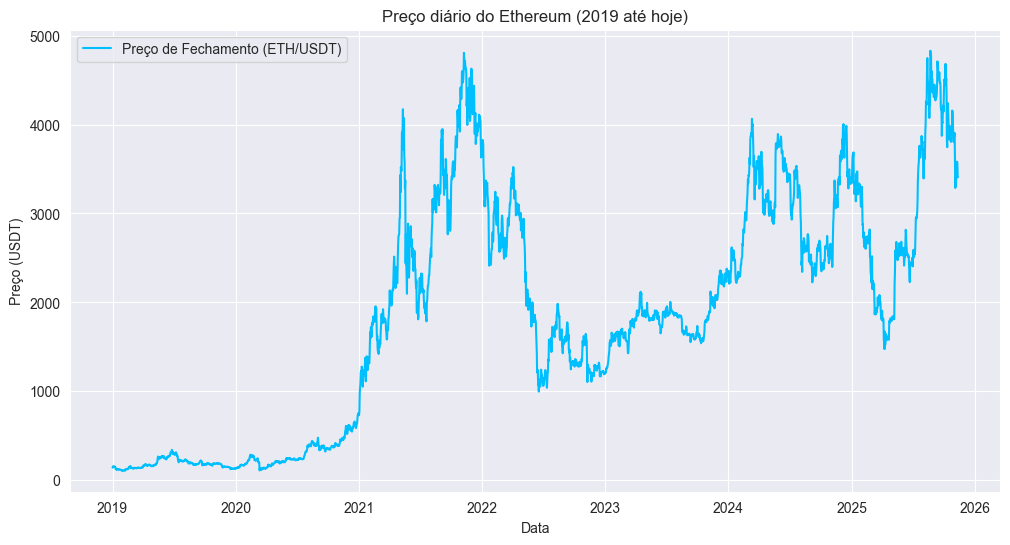

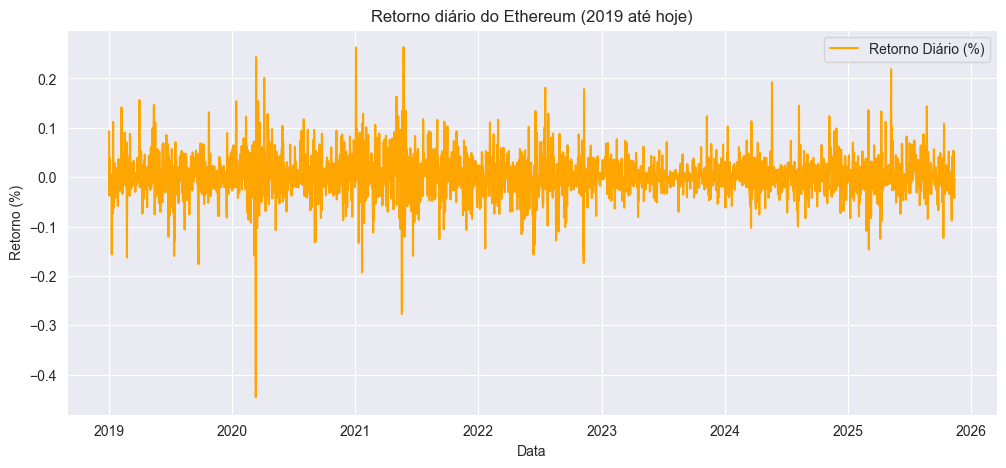

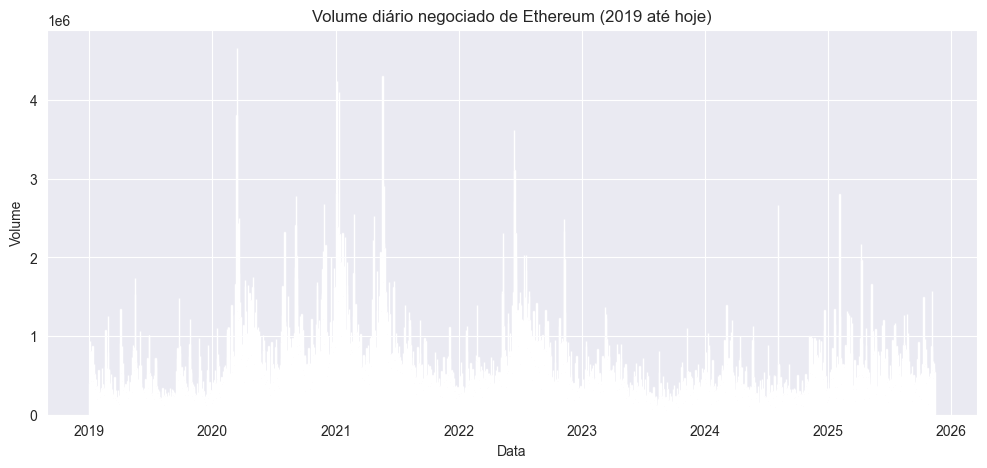

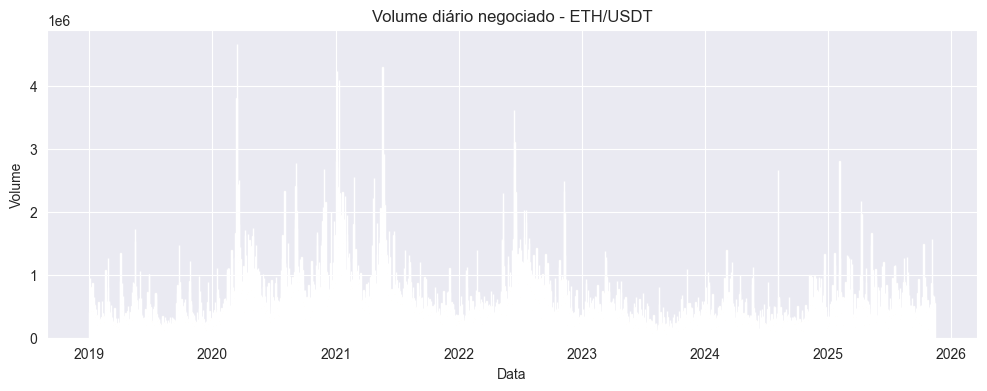

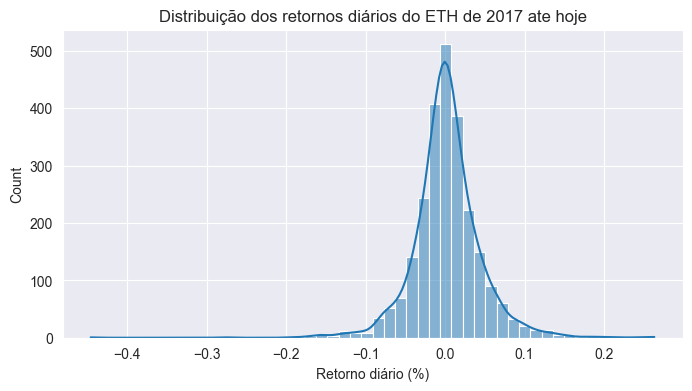

In [37]:
# ==============================
# Gráfico de preço
# ==============================
plt.figure(figsize=(12,6))
plt.plot(ETH_df["open_time"], ETH_df["close"], label="Preço de Fechamento (ETH/USDT)", color="deepskyblue")
plt.title("Preço diário do Ethereum (2019 até hoje)")
plt.xlabel("Data")
plt.ylabel("Preço (USDT)")
plt.legend()
plt.grid(True)
plt.show()


# Gráfico 2: Retornos diários
plt.figure(figsize=(12,5))
plt.plot(ETH_df["open_time"], ETH_df["return"], color='orange', label="Retorno Diário (%)")
plt.title("Retorno diário do Ethereum (2019 até hoje)")
plt.xlabel("Data")
plt.ylabel("Retorno (%)")
plt.legend()
plt.grid(True)
plt.show()

# Gráfico 3: Volume negociado
plt.figure(figsize=(12,5))
plt.bar(ETH_df["open_time"], ETH_df["volume"], color='purple')
plt.title("Volume diário negociado de Ethereum (2019 até hoje)")
plt.xlabel("Data")
plt.ylabel("Volume")
plt.grid(True)
plt.show()


# Volume negociado
plt.figure(figsize=(12,4))
plt.bar(ETH_df["open_time"], ETH_df["volume"], color="orange")
plt.title("Volume diário negociado - ETH/USDT")
plt.xlabel("Data")
plt.ylabel("Volume")
plt.show()

# Distribuição dos retornos
plt.figure(figsize=(8,4))
sns.histplot(ETH_df["return"].dropna(), bins=50, kde=True)
plt.title("Distribuição dos retornos diários do ETH de 2017 ate hoje")
plt.xlabel("Retorno diário (%)")
plt.show()


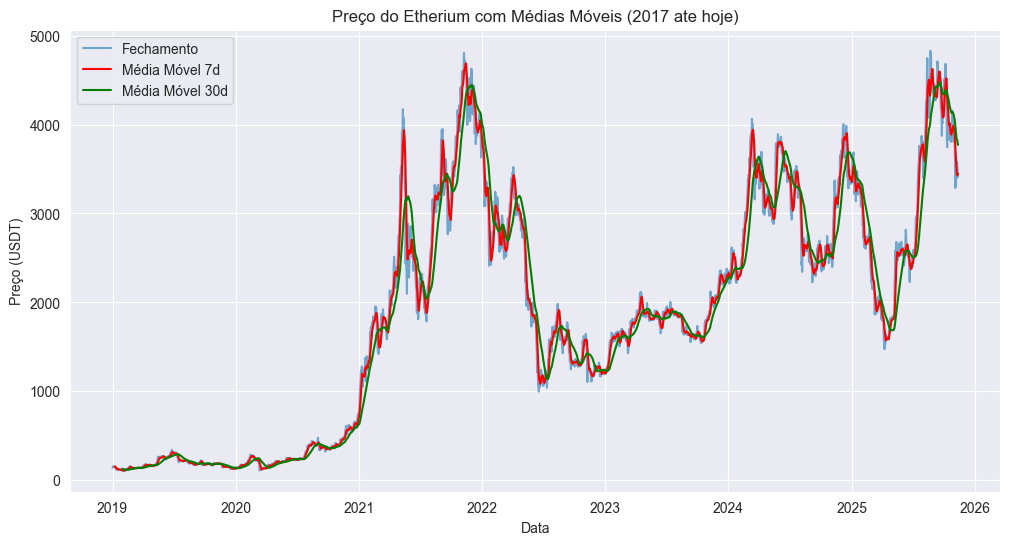

In [38]:
# ==============================
# FEATURE ENGINEERING (para predição futura)
# ==============================
# Médias móveis (tendência)
ETH_df["SMA_7"] = ETH_df["close"].rolling(window=7).mean()   # 1 semana
ETH_df["SMA_30"] = ETH_df["close"].rolling(window=30).mean() # 1 mês

# Volatilidade (desvio padrão dos retornos)
ETH_df["volatilidade_7d"] = ETH_df["return"].rolling(window=7).std()

# Gráfico com médias móveis
plt.figure(figsize=(12,6))
plt.plot(ETH_df["open_time"], ETH_df["close"], label="Fechamento", alpha=0.6)
plt.plot(ETH_df["open_time"], ETH_df["SMA_7"], label="Média Móvel 7d", color="red")
plt.plot(ETH_df["open_time"], ETH_df["SMA_30"], label="Média Móvel 30d", color="green")
plt.title("Preço do Etherium com Médias Móveis (2017 ate hoje)")
plt.xlabel("Data")
plt.ylabel("Preço (USDT)")
plt.legend()
plt.grid(True)
plt.show()


In [39]:

# ==============================
# Resultado final
# ==============================
print("\nAnálise exploratória concluída com sucesso!")
print("Linhas analisadas:", len(ETH_df))
ETH_df.tail()



Análise exploratória concluída com sucesso!
Linhas analisadas: 2508


,open_time,open,high,low,close,volume,return,SMA_7,SMA_30,volatilidade_7d
2503,2025-11-08,3436.04,3488.00,3355.58,3401.51,291532.2881,-0.010052,3482.064286,3838.118333,0.051504
2504,2025-11-09,3401.51,3623.25,3358.66,3583.46,464098.0520,0.053491,3435.904286,3829.909667,0.057688
2505,2025-11-10,3583.46,3658.98,3507.30,3567.85,595273.0298,-0.004356,3430.764286,3823.945000,0.049660
2506,2025-11-11,3567.85,3648.27,3405.24,3417.76,660283.2747,-0.042067,3449.437143,3799.460667,0.037797
2507,2025-11-12,3417.76,3588.19,3371.65,3410.25,544895.2423,-0.002197,3447.431429,3771.774000,0.034404
